In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from util import (
    RAW_DATA_DIR,
    DATASET_TYPE,
    LAYER_1_CLASSES,
    LAYER_2_CLASSES,
    LAYER_3_CLASSES,
    PROCESSED_DATA_DIR,
    transform_column_name,
)

# Silence warnings
register_matplotlib_converters()

# Extend the default number of rows we see
pd.set_option("display.max_rows", 500)

# Use a pleasant typeface. Set the graph DPI. Remove top and right lines in
# plot. NOTE: Comment the font out before autograder submission!
# plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.family"] = "Circular"
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["legend.fontsize"] = "small"
plt.rcParams["legend.fancybox"] = False


# Initial Data Exploration

This notebook is an initial exploration of the supplied raw datasets. It generates the `000-initial-run_layer_*.parquet` files in `../data`.

In [2]:
# Get the headers first. Easy.

medical_claims_headers = list(
    pd.read_excel(f"{RAW_DATA_DIR}/Data Dictionary Medical Claims.xlsx", header=[1])[
        "Field"
    ]
)
pharmacy_claims_headers = list(
    pd.read_excel(f"{RAW_DATA_DIR}/Data Dictionary Pharmacy Claims.xlsx", header=[1])[
        "Field"
    ]
)

print(f"There are {len(medical_claims_headers)} features in the medical dataset")
print(f"There are {len(pharmacy_claims_headers)} features in the pharmacy dataset")


There are 84 features in the medical dataset
There are 51 features in the pharmacy dataset


In [3]:
# Medical Claims.
medical_data_dir = Path(f"{RAW_DATA_DIR}/Medical_Claims/{DATASET_TYPE}")
medical_data_raw_df = pd.concat(
    pd.read_parquet(parquet_file, engine="pyarrow")
    for parquet_file in medical_data_dir.glob("*.parquet")
)

# We ignore the last column (because it's repeated and was discussed in the
# Teams channel) and set the headers
medical_data_raw_df = medical_data_raw_df.iloc[:, :84]
medical_data_raw_df.columns = medical_claims_headers


In [4]:
# Pharmacy Claims.
pharmacy_data_dir = Path(f"{RAW_DATA_DIR}/Pharmacy_Claims/{DATASET_TYPE}")
pharmacy_data_raw_df = pd.concat(
    pd.read_parquet(parquet_file, engine="pyarrow")
    for parquet_file in pharmacy_data_dir.glob("*.parquet")
)

# We ignore the last three columns of the headers (since they're not present in
# the dataset)
pharmacy_data_raw_df.columns = pharmacy_claims_headers[:48]


## Raw Data Preparation


In [5]:
total_raw_medical_encounters = len(medical_data_raw_df)
total_raw_pharmacy_encounters = len(pharmacy_data_raw_df)

print(f"{total_raw_medical_encounters} total medical encounters")
print(f"{total_raw_pharmacy_encounters} total pharmacy encounters")
print(
    f"{len(medical_data_raw_df['Member Life ID'].unique())} unique patients at the hospital"
)
print(
    f"{len(pharmacy_data_raw_df['Member Life ID'].unique())} unique patients at the pharmacy"
)


8092330 total medical encounters
2570133 total pharmacy encounters
100000 unique patients at the hospital
54001 unique patients at the pharmacy


In [6]:
# Filter out observations that do NOT have a Primary Diagnosis ICD10 code.
no_primary_codes = len(
    medical_data_raw_df[medical_data_raw_df["Primary Diagnosis Code-ICD10"] == "*"]
)
print(f"There are {no_primary_codes} observations with no PRIMARY ICD10 codes")

medical_data_raw_df_filter_1 = medical_data_raw_df[
    medical_data_raw_df["Primary Diagnosis Code-ICD10"] != "*"
]
print(f"Filtered dataset now contains {len(medical_data_raw_df_filter_1)} observations")


There are 80 observations with no PRIMARY ICD10 codes
Filtered dataset now contains 8092250 observations


How many of these have missing "Medical Life ID"s?


In [7]:
print(len(medical_data_raw_df[medical_data_raw_df["Member Life ID"] == "-1"]))
print(
    len(medical_data_raw_df[medical_data_raw_df["Member Life ID"] == "-1"])
    / total_raw_medical_encounters
)


195498
0.024158431502422664


In [8]:
print(len(pharmacy_data_raw_df[pharmacy_data_raw_df["Member Life ID"] == "-1"]))
print(
    len(pharmacy_data_raw_df[pharmacy_data_raw_df["Member Life ID"] == "-1"])
    / total_raw_pharmacy_encounters
)


1057426
0.4114285136216686


### Features of Interest


In [9]:
"""
NOTE: These were initially picked by hand using @sshyam3 as a domain expert.
"""

FEATURES_OF_INTEREST_MEDICAL = [
    "Member Life ID",
    # "Jurisdiction",
    "Gender Code",
    # "Current Procedural Terminology",
    # "CPT Modifier 1",
    # "CPT Modifier 2",
    "Primary Diagnosis Code-ICD10",
    "Secondary Diagnosis Code-ICD10",
    "Tertiary Diagnosis Code-ICD10",
    # "Discharge Status",
    "Admission Date",
    # "Discharge Date",
    "# of submitted Inpatient Days",
    "# of Services",
    # "Billed Amount",
]

medical_data_raw_df_filter_2 = medical_data_raw_df_filter_1[
    FEATURES_OF_INTEREST_MEDICAL
]


Next we just get the dates of birth from the pharmacy claims dataset


In [10]:
FEATURES_OF_INTEREST_PHARMACY = [
    "Member Life ID",
    "Birth Date",
]

pharmacy_data_raw_df_filter_1 = pharmacy_data_raw_df[FEATURES_OF_INTEREST_PHARMACY]


### Data Type Conversion


In [11]:
from datetime import date, datetime


medical_data_raw_df_transform_1 = medical_data_raw_df_filter_2.astype(
    {"Member Life ID": int, "# of submitted Inpatient Days": int, "# of Services": int}
)


In [12]:
pharmacy_data_raw_df_transform_1 = pharmacy_data_raw_df_filter_1.astype(
    {
        "Member Life ID": int,
    }
)


### Date Exploration


We have these many dates that look like 9999-12-31. Don't know what these are
just yet. Two possibilities:

1. Unknown/unrecorded admission date
2. From the year 2000 (this is very unlikely... or is it?)


In [13]:
len(
    medical_data_raw_df_transform_1[
        medical_data_raw_df_transform_1["Admission Date"].str.contains("9999")
    ]
)


7322575

Now we see how many dates do NOT contain hyphens, which we take to mean invalid or missing dates


In [14]:
len(
    medical_data_raw_df_transform_1[
        ~medical_data_raw_df_transform_1["Admission Date"].str.contains("-")
    ]
)


0

Looks like we have dates for all admissions! _Many_ of them are weird (`9999-12-31`) but we do have them. We need to figure out what to do with them.

First let's try to figure out the earliest and latest admission dates. Since the format (luckily) is `YYYY-MM-DD`, we can just rely on a lexicographic sort here. Just remove the `9999` years for now (until we figure out what to do with them...)


In [15]:
temp = medical_data_raw_df_transform_1[
    ~medical_data_raw_df_transform_1["Admission Date"].str.contains("9999")
].sort_values(by=["Admission Date"])
len(temp)


769675

So! The earliest admission date is `1959-04-02` (!!!) and the latest is `2019-08-22`. _However_ this is only for ~9% of the data! We might have to discard "Age at Admission" as a predictor...


Let's look at the pharmacy data. It contains an important (we think) field: the Date of Birth.


In [16]:
# Here's where the 'fun' begins. We have 54,001 unique member life IDs in the
# pharmacy dataset. However, when we drop duplicates, we get 61,744. What's
# going on?

pharmacy_data_raw_df_transform_2 = pharmacy_data_raw_df_transform_1.drop_duplicates(
    subset=["Member Life ID", "Birth Date"]
)
len(pharmacy_data_raw_df_transform_2)


61744

In [17]:
# Let's dedupe the data
_ids = pharmacy_data_raw_df_transform_2["Member Life ID"]

pharmacy_data_raw_df_transform_2 = pharmacy_data_raw_df_transform_2[
    _ids.isin(_ids[_ids.duplicated()])
].sort_values("Member Life ID")

pharmacy_data_raw_df_transform_2


,Member Life ID,Birth Date
244982,-1,1952-11-03
333331,-1,1934-09-19
333299,-1,1935-03-24
333236,-1,1935-03-21
333231,-1,1947-04-03
...,...,...
17204,35489574,1995-02-16
31919,35843551,1961-02-02
16573,35843551,1961-02-07
19448,35909281,2011-05-02


In [18]:
pharmacy_data_raw_df_transform_2[
    pharmacy_data_raw_df_transform_2["Member Life ID"] == -1
]


,Member Life ID,Birth Date
244982,-1,1952-11-03
333331,-1,1934-09-19
333299,-1,1935-03-24
333236,-1,1935-03-21
333231,-1,1947-04-03
...,...,...
140368,-1,1943-08-04
140406,-1,1943-09-07
140418,-1,1943-07-09
139948,-1,1943-06-17


So it turns out

- We have 'missing' Member Life IDs (denoted by `-1`)
- We have Member Life IDs that have _duplicate_ birth dates (yay!)
- 54,001 + 7510 = 61,511.
- We are still 233 IDs short of a complete explanation. These ostensibly are member IDs who have pharmacy claims but _not_ medical claims!

Now even if we figure out a simple median/mean age based on the pharma dataset, we are still missing another important date in the _medical_ dataset: the date of admission. As of now, and until we gain clarity on what `9999-12-31` means (which occupies ~90%+ of the medical dataset) we will discard our pursuit of "Age at Admission" and keep moving 🤷‍♀️


In [19]:
medical_data_raw_df_transform_2 = medical_data_raw_df_transform_1.drop(
    columns=["Admission Date"]
)


In [20]:
medical_data_raw_df_transform_2[medical_data_raw_df_transform_2["Member Life ID"] == 38541263]
# medical_data_raw_df_transform_2

,Member Life ID,Gender Code,Primary Diagnosis Code-ICD10,Secondary Diagnosis Code-ICD10,Tertiary Diagnosis Code-ICD10,# of submitted Inpatient Days,# of Services
19232,38541263,M,Z00129,*,*,0,1
19233,38541263,M,L309,*,*,0,1
253754,38541263,M,Z23,*,*,0,2
253755,38541263,M,Z23,*,*,0,1
323286,38541263,M,Z23,*,*,0,3
323287,38541263,M,Z23,*,*,0,1
323288,38541263,M,Z23,*,*,0,1
333759,38541263,M,Z23,*,*,0,1
333760,38541263,M,Z00129,*,*,0,1
333761,38541263,M,Z23,*,*,0,1


### Miscellaneous Predictors


#### Number of Submitted InPatient Days


In [21]:
_ = len(
    medical_data_raw_df_transform_2[
        medical_data_raw_df_transform_2["# of submitted Inpatient Days"] < 0
    ]
)
print(
    f"{_ / len(medical_data_raw_df_transform_2) * 100 }% have negative submitted inpatient days"
)


0.0496400877382681% have negative submitted inpatient days


However, zero is OK. It looks like > ~99% of visits were not in-patient hospital visits (i.e. not in a hospital setting).


In [22]:
_ = len(
    medical_data_raw_df_transform_2[
        medical_data_raw_df_transform_2["# of submitted Inpatient Days"] == 0
    ]
)
print(
    f"{_ / len(medical_data_raw_df_transform_2) * 100 }% have zerob submitted inpatient days"
)


99.57582872501467% have zerob submitted inpatient days


This is a very sparse vector so we just drop it.


In [23]:
medical_data_raw_df_transform_3 = medical_data_raw_df_transform_2.drop(
    columns=["# of submitted Inpatient Days"]
)


#### Number of Services


In [24]:
_ = len(
    medical_data_raw_df_transform_2[
        medical_data_raw_df_transform_2["# of Services"] <= 0
    ]
)
print(
    f"{_ / len(medical_data_raw_df_transform_2) * 100 }% have zero or negative number of services"
)

_ = len(
    medical_data_raw_df_transform_2[
        medical_data_raw_df_transform_2["# of Services"] == 1
    ]
)
print(f"{_ / len(medical_data_raw_df_transform_2) * 100 }% have exactly one service")


4.815965893292966% have zero or negative number of services
82.20075998640675% have exactly one service


In [25]:
medical_data_raw_df_transform_2["# of Services"].describe()


count    8.092250e+06
mean     3.755307e+00
std      5.340344e+01
min     -1.000000e+04
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+04
Name: # of Services, dtype: float64

TODO: At this point, this predictor will not add any value to our explorations/model-building. So drop it (for now).


In [26]:
medical_data_raw_df_transform_3 = medical_data_raw_df_transform_2.drop(
    columns=["# of Services"]
)


#### Gender Codes


OK so what do gender codes look like? M/F are not the only sexes!


In [27]:
gender_code_total = len(medical_data_raw_df_transform_3)
M = len(
    medical_data_raw_df_transform_3[
        medical_data_raw_df_transform_3["Gender Code"] == "M"
    ]
)
F = len(
    medical_data_raw_df_transform_3[
        medical_data_raw_df_transform_3["Gender Code"] == "F"
    ]
)
U = gender_code_total - (M + F)

print(
    f"{M + F} records have M/F gender codes out of {gender_code_total} ({U} unknown/intersex)"
)


8092178 records have M/F gender codes out of 8092250 (72 unknown/intersex)


What is the coding for "unknown/intersex"?


In [28]:
medical_data_raw_df_transform_3["Gender Code"].unique()


array(['M', 'F', 'U'], dtype=object)

## Final Raw Dataframe

Here we summarize our explorations in the form of a dataset/frame we can work with to build our model(s). First we capture the ICD10 disease classes [from here](https://www.icd10data.com/ICD10CM/Codes). There are 22 "Layer One" classes (that's what I'm caling them) which are pretty broad and 283 "Layer Two" classes which are a bit more specific. We can capture more with webscraping but let's start with these. See the `scripts` folder for where we define these classes.


In [29]:
len(LAYER_1_CLASSES.keys())


21

In [30]:
len(LAYER_2_CLASSES.keys())


255

In [31]:
medical_data_raw_df_transform_4 = medical_data_raw_df_transform_3.copy()

_cols = [
    "Primary Diagnosis Code-ICD10",
    "Secondary Diagnosis Code-ICD10",
    "Tertiary Diagnosis Code-ICD10",
]


for i, c in enumerate(_cols):
    medical_data_raw_df_transform_4[f"ICD10_{i+1}"] = medical_data_raw_df_transform_3[
        c
    ].apply(lambda _: _[:3])

medical_data_raw_df_transform_4.drop(columns=_cols, inplace=True)
medical_data_raw_df_transform_4.drop(
    columns=["# of submitted Inpatient Days"], inplace=True
)


In [32]:
# Sample member visits
# medical_data_raw_df_transform_2[medical_data_raw_df_transform_2["Member Life ID"] == 2690481]

medical_data_raw_df_transform_4


,Member Life ID,Gender Code,ICD10_1,ICD10_2,ICD10_3
0,236523,M,R50,I48,J98
1,236523,M,R50,I48,J98
2,236523,M,Z00,I48,Z00
3,236523,M,Z00,I48,*
4,236523,M,R14,*,*
...,...,...,...,...,...
399371,651301,M,J44,I13,I50
399372,3109406,F,L43,*,*
399373,3109406,F,L43,*,*
399374,3109406,F,L29,*,*


In [33]:
(
    medical_data_raw_df_transform_3["Primary Diagnosis Code-ICD10"].nunique()
    + medical_data_raw_df_transform_3["Secondary Diagnosis Code-ICD10"].nunique()
    + medical_data_raw_df_transform_3["Tertiary Diagnosis Code-ICD10"].nunique()
)

medical_data_raw_df_transform_3["Primary Diagnosis Code-ICD10"]


0          R509
1          R509
2         Z0000
3         Z0000
4          R140
          ...  
399371     J449
399372     L438
399373     L438
399374     L298
399375    Z1231
Name: Primary Diagnosis Code-ICD10, Length: 8092250, dtype: object

In [34]:
(
    medical_data_raw_df_transform_4["ICD10_1"].nunique()
    + medical_data_raw_df_transform_4["ICD10_2"].nunique()
    + medical_data_raw_df_transform_4["ICD10_3"].nunique()
)

len(
    medical_data_raw_df_transform_4[
        medical_data_raw_df_transform_4["Member Life ID"] < 0
    ]
)


195497

In [35]:
medical_data_raw_df_transform_4["Member Life ID"].value_counts()
len(medical_data_raw_df_transform_4)


8092250

In [36]:
# TODO: Randomize these instead of removing them!

# Remove all -1's... they're a measly 2.41% of the dataset
medical_data_raw_df_transform_5 = medical_data_raw_df_transform_4[
    medical_data_raw_df_transform_4["Member Life ID"] != -1
]
print(
    f"There are {len(medical_data_raw_df_transform_5)} encounters in the medical dataset"
)


There are 7896753 encounters in the medical dataset


In [37]:
encounter_counts = medical_data_raw_df_transform_5["Member Life ID"].value_counts()
encounter_counts.describe()


count    99999.000000
mean        78.968320
std        147.033544
min          1.000000
25%         15.000000
50%         37.000000
75%         88.000000
max       4659.000000
Name: Member Life ID, dtype: float64

In [38]:
len(medical_data_raw_df_transform_5)


7896753

In [39]:
medical_data_raw_df_transform_6 = medical_data_raw_df_transform_5.drop_duplicates()
medical_data_raw_df_transform_7 = medical_data_raw_df_transform_6[
    medical_data_raw_df_transform_6["Gender Code"] != "U"
]


In [40]:
medical_data_raw_df_transform_7["Member Life ID"].value_counts()


3214401     484
70279       363
1181665     361
2969891     356
386441      353
           ... 
35820325      1
35688843      1
1478516       1
34028536      1
33580755      1
Name: Member Life ID, Length: 99999, dtype: int64

In [41]:
medical_data_raw_df_transform_7


,Member Life ID,Gender Code,ICD10_1,ICD10_2,ICD10_3
0,236523,M,R50,I48,J98
2,236523,M,Z00,I48,Z00
3,236523,M,Z00,I48,*
4,236523,M,R14,*,*
5,236523,M,M62,*,*
...,...,...,...,...,...
399281,521991,M,R77,G62,R10
399292,31578945,M,Z23,I10,E78
399317,384290,F,R06,*,*
399337,709103,F,Z12,Z92,*


In [42]:
# Encode M/F as binary values
medical_data_raw_df_transform_8 = medical_data_raw_df_transform_7.copy()
medical_data_raw_df_transform_8["Gender Code"].replace("M", 0, inplace=True)
medical_data_raw_df_transform_8["Gender Code"].replace("F", 1, inplace=True)

number_of_rows = len(medical_data_raw_df_transform_8)


In [43]:
number_of_rows


1768734

In [44]:
# NOTE: This is faster than concat but with larger numbers of columns, Pandas
# complains :/
#
# for _class in LAYER_1_CLASSES.keys():
#     medical_data_raw_df_transform_9_layer_1[_class] = np.zeros(number_of_rows)

# NOTE: We are resetting the index too after deduplication!

reset_index = medical_data_raw_df_transform_8.copy().reset_index(drop=True)

medical_data_raw_df_transform_9_layer_1 = pd.concat(
    [
        reset_index,
        pd.DataFrame(
            np.zeros((number_of_rows, len(LAYER_1_CLASSES.keys()))),
            columns=LAYER_1_CLASSES.keys(),
        ),
    ],
    axis=1,
)

medical_data_raw_df_transform_9_layer_2 = pd.concat(
    [
        reset_index,
        pd.DataFrame(
            np.zeros((number_of_rows, len(LAYER_2_CLASSES.keys()))),
            columns=LAYER_2_CLASSES.keys(),
        ),
    ],
    axis=1,
)


In [45]:
# Layer 3 setup
# medical_data_raw_df_transform_9_layer_3 = pd.concat(
#     [
#         medical_data_raw_df_transform_8.copy().reset_index(drop=True),
#         pd.DataFrame(
#             np.zeros((number_of_rows, len(LAYER_3_CLASSES.keys()))),
#             columns=LAYER_3_CLASSES.keys(),
#         ),
#     ],
#     axis=1,
# )

# medical_data_raw_df_transform_9_layer_3[LAYER_3_CLASSES.keys()] = pd.DataFrame(
#     np.zeros((number_of_rows, len(LAYER_3_CLASSES.keys()))),
#     # columns=LAYER_3_CLASSES.keys(),
# )

medical_data_raw_df_transform_9_layer_3 = reset_index

# This yells at you but is MUCH faster than .join or .concat or .merge. I have
# tried everything and have no idea why these things run as slowly as they do.
for _class in LAYER_3_CLASSES.keys():
    medical_data_raw_df_transform_9_layer_3[_class] = np.zeros(number_of_rows)


/var/folders/rz/35hypw317b7dnkzx7bjsw70w0000gq/T/ipykernel_97668/253469130.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  medical_data_raw_df_transform_9_layer_3[_class] = np.zeros(number_of_rows)
/var/folders/rz/35hypw317b7dnkzx7bjsw70w0000gq/T/ipykernel_97668/253469130.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  medical_data_raw_df_transform_9_layer_3[_class] = np.zeros(number_of_rows)
/var/folders/rz/35hypw317b7dnkzx7bjsw70w0000gq/T/ipykernel_97668/253469130.py:23: PerformanceWarning: DataFrame is highly fragme

Verify shapes. The number of rows should be the same!

In [46]:
for _ in [1, 2, 3]:
    print(f"Layer {_} has shape {eval(f'medical_data_raw_df_transform_9_layer_{_}').shape}")

Layer 1 has shape (1768734, 26)
Layer 2 has shape (1768734, 260)
Layer 3 has shape (1768734, 1651)


In [47]:
# TODO: Do we 'collapse' all ICD code observations for a single member life ID?
# Or do we 'reinforce' the occurence of ICD10 clusters?
medical_data_raw_df_transform_9_layer_1[
    medical_data_raw_df_transform_9_layer_1["Member Life ID"] == 236523
]


,Member Life ID,Gender Code,ICD10_1,ICD10_2,ICD10_3,A00_B99,C00_D49,D50_D89,E00_E89,F01_F99,...,L00_L99,M00_M99,N00_N99,O00_O9A,P00_P96,Q00_Q99,R00_R99,S00_T88,U00_U85,Z00_Z99
0,236523,0,R50,I48,J98,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,236523,0,Z00,I48,Z00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,236523,0,Z00,I48,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,236523,0,R14,*,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,236523,0,M62,*,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,236523,0,R00,R00,I48,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,236523,0,R50,Z98,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,236523,0,I48,I10,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,236523,0,J20,J20,J30,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,236523,0,I48,J20,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plots for the Mid Term Report


### Distribution of Genders


Text(0.5, 0, 'Gender')

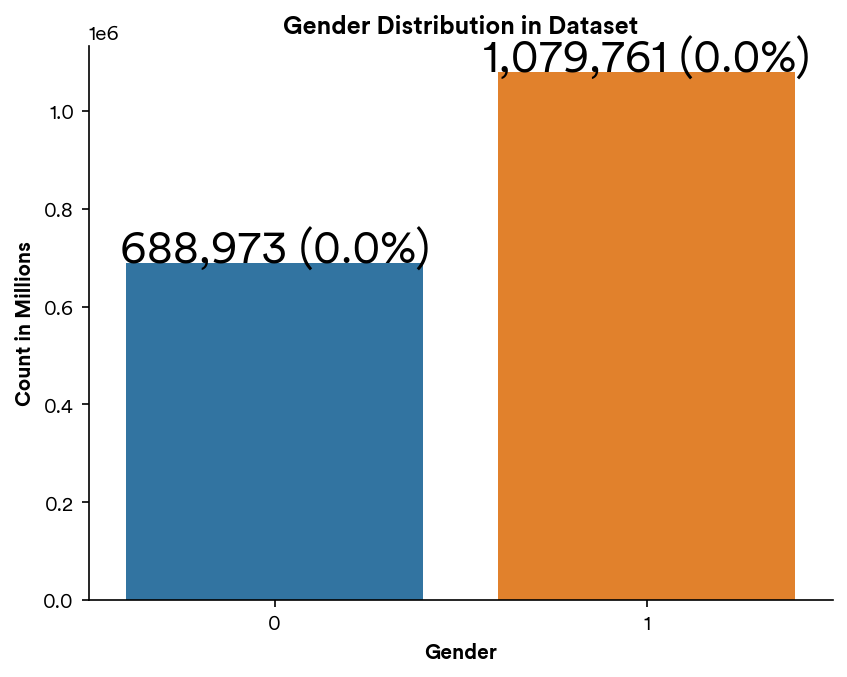

In [48]:
ax = sns.countplot(x=medical_data_raw_df_transform_9_layer_1["Gender Code"])

counts = [
    round(
        len(
            medical_data_raw_df_transform_9_layer_1[
                medical_data_raw_df_transform_9_layer_1["Gender Code"] == "M"
            ]
        )
        / len(medical_data_raw_df_transform_9_layer_1)
        * 100,
        2,
    ),
    round(
        len(
            medical_data_raw_df_transform_9_layer_1[
                medical_data_raw_df_transform_9_layer_1["Gender Code"] == "F"
            ]
        )
        / len(medical_data_raw_df_transform_9_layer_1)
        * 100,
        2,
    ),
]

for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(
        i,  # bar index (x coordinate of text)
        h,  # y coordinate of text
        "{:,} ({}%)".format(int(h), counts[i]),  # y label
        ha="center",
        # va="top",
        size=22,
    )
plt.title("Gender Distribution in Dataset", fontweight="bold")
plt.ylabel("Count in Millions", fontweight="bold")
plt.xlabel("Gender", fontweight="bold")


### Distribution of Encounters


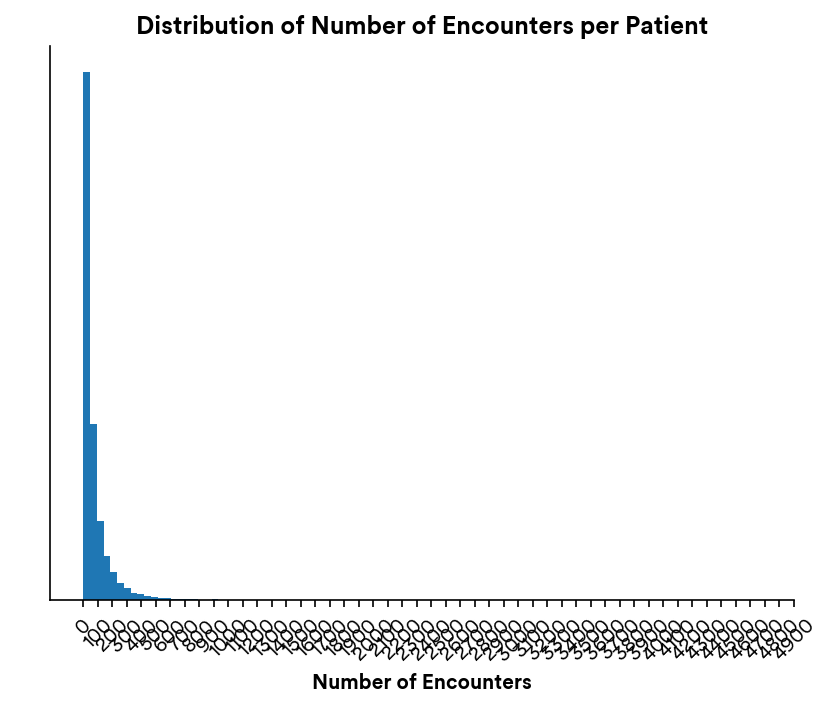

<Figure size 960x720 with 0 Axes>

In [49]:
pd.DataFrame(encounter_counts).plot.hist(bins=100)

# bar = pd.DataFrame([3,4,5,15, 6, 6])
# sns.histplot(bar)
plt.title("Distribution of Number of Encounters per Patient", fontweight="bold")

plt.xticks(np.arange(0, 5000, step=100))
plt.xticks(rotation=45)
plt.yticks([])
plt.xlabel("Number of Encounters", fontweight="bold")
plt.ylabel(" ")
plt.legend().remove()
plt.show()

plt.clf()


####


## Dataframes for the Next Stage


### Layer 1


In [50]:
# medical_data_raw_df_transform_10_layer_1 = (
#     medical_data_raw_df_transform_9_layer_1.copy()
# )
# medical_data_raw_df_transform_10_layer_2 = (
#     medical_data_raw_df_transform_9_layer_2.copy()
# )
# medical_data_raw_df_transform_10_layer_3 = (
#     medical_data_raw_df_transform_9_layer_3.copy()
# )

In [51]:
print("Removing ICD10 codes starting with numbers")

medical_data_raw_df_transform_10_layer_1 = medical_data_raw_df_transform_9_layer_1[
    ~medical_data_raw_df_transform_9_layer_1["ICD10_1"].str.isnumeric()
    & ~medical_data_raw_df_transform_9_layer_1["ICD10_2"].str.isnumeric()
    & ~medical_data_raw_df_transform_9_layer_1["ICD10_3"].str.isnumeric()
]

print(f"Layer 1 has shape {medical_data_raw_df_transform_10_layer_1.shape}")

medical_data_raw_df_transform_10_layer_2 = medical_data_raw_df_transform_9_layer_2[
    ~medical_data_raw_df_transform_9_layer_2["ICD10_1"].str.isnumeric()
    & ~medical_data_raw_df_transform_9_layer_2["ICD10_2"].str.isnumeric()
    & ~medical_data_raw_df_transform_9_layer_2["ICD10_3"].str.isnumeric()
]

print(f"Layer 2 has shape {medical_data_raw_df_transform_10_layer_2.shape}")

medical_data_raw_df_transform_10_layer_3 = medical_data_raw_df_transform_9_layer_3[
    ~medical_data_raw_df_transform_9_layer_3["ICD10_1"].str.isnumeric()
    & ~medical_data_raw_df_transform_9_layer_3["ICD10_2"].str.isnumeric()
    & ~medical_data_raw_df_transform_9_layer_3["ICD10_3"].str.isnumeric()
]

print(f"Layer 3 has shape {medical_data_raw_df_transform_10_layer_3.shape}")


Removing ICD10 codes starting with numbers
Layer 1 has shape (1768599, 26)
Layer 2 has shape (1768599, 260)
Layer 3 has shape (1768599, 1651)


In [52]:
print("Checking (visually) to make sure we don't have numbers or NaNs\n")

for layer_number in [1, 2, 3]:
    print(f"Checking Layer {layer_number}")
    for icd10_level in [1, 2, 3]:
        print(
            f"ICD10_{icd10_level}",
            eval(f"medical_data_raw_df_transform_10_layer_{layer_number}")[
                f"ICD10_{icd10_level}"
            ]
            .str[:1]
            .unique(),
        )
    print("\n")


Checking (visually) to make sure we don't have numbers or NaNs

Checking Layer 1
ICD10_1 ['R' 'Z' 'M' 'I' 'J' 'G' 'K' 'O' 'H' 'B' 'N' 'C' 'L' 'S' 'Q' 'E' 'D' 'F'
 'T' 'P' 'V' 'A' 'W' 'Y' 'X']
ICD10_2 ['I' '*' 'R' 'Z' 'J' 'E' 'M' 'K' 'H' 'N' 'C' 'L' 'G' 'Q' 'D' 'S' 'B' 'F'
 'P' 'A' 'Y' 'O' 'W' 'T' 'X' 'V']
ICD10_3 ['J' 'Z' '*' 'I' 'G' 'K' 'M' 'R' 'Q' 'D' 'E' 'L' 'F' 'H' 'Y' 'S' 'A' 'N'
 'B' 'O' 'W' 'P' 'C' 'T' 'X' 'V']


Checking Layer 2
ICD10_1 ['R' 'Z' 'M' 'I' 'J' 'G' 'K' 'O' 'H' 'B' 'N' 'C' 'L' 'S' 'Q' 'E' 'D' 'F'
 'T' 'P' 'V' 'A' 'W' 'Y' 'X']
ICD10_2 ['I' '*' 'R' 'Z' 'J' 'E' 'M' 'K' 'H' 'N' 'C' 'L' 'G' 'Q' 'D' 'S' 'B' 'F'
 'P' 'A' 'Y' 'O' 'W' 'T' 'X' 'V']
ICD10_3 ['J' 'Z' '*' 'I' 'G' 'K' 'M' 'R' 'Q' 'D' 'E' 'L' 'F' 'H' 'Y' 'S' 'A' 'N'
 'B' 'O' 'W' 'P' 'C' 'T' 'X' 'V']


Checking Layer 3
ICD10_1 ['R' 'Z' 'M' 'I' 'J' 'G' 'K' 'O' 'H' 'B' 'N' 'C' 'L' 'S' 'Q' 'E' 'D' 'F'
 'T' 'P' 'V' 'A' 'W' 'Y' 'X']
ICD10_2 ['I' '*' 'R' 'Z' 'J' 'E' 'M' 'K' 'H' 'N' 'C' 'L' 'G' 'Q' 'D' 'S' 'B' 'F'
 'P' 'A

Some final transformations. We

- Sort by the Member Life IDs. Order is super important in the next few
- Reset the Index per superstition to keep it nice and 'refreshed' and 'clean'
- Turn the column names to something we can use with a named tuple


In [53]:
# --- Layer 1 ---
print("Starting Layer 1")
medical_data_raw_df_transform_11_layer_1 = (
    medical_data_raw_df_transform_10_layer_1.sort_values(by="Member Life ID")
)
medical_data_raw_df_transform_11_layer_1.reset_index(drop=True, inplace=True)
medical_data_raw_df_transform_11_layer_1.columns = [
    transform_column_name(c) for c in medical_data_raw_df_transform_11_layer_1.columns
]

print(f"Layer 1 has shape {medical_data_raw_df_transform_11_layer_1.shape}")
print(f"Writing parquet file")

medical_data_raw_df_transform_11_layer_1.to_parquet(
    f"{PROCESSED_DATA_DIR}/000-initial-run_layer_1.parquet"
)


Starting Layer 1
Layer 1 has shape (1768599, 26)
Writing parquet file


In [54]:
medical_data_raw_df_transform_11_layer_1.head()

,Member_Life_ID,Gender_Code,ICD10_1,ICD10_2,ICD10_3,A00_B99,C00_D49,D50_D89,E00_E89,F01_F99,...,L00_L99,M00_M99,N00_N99,O00_O9A,P00_P96,Q00_Q99,R00_R99,S00_T88,U00_U85,Z00_Z99
0,154,0,R06,Z74,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,154,0,I10,I50,N18,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,154,0,N18,E88,I50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,154,0,I48,I50,J96,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,154,0,I50,I48,J90,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# --- Layer 2 ---
print("Starting Layer 2")
medical_data_raw_df_transform_11_layer_2 = (
    medical_data_raw_df_transform_10_layer_2.sort_values(by="Member Life ID")
)
medical_data_raw_df_transform_11_layer_2.reset_index(drop=True, inplace=True)
medical_data_raw_df_transform_11_layer_2.columns = [
    transform_column_name(c) for c in medical_data_raw_df_transform_11_layer_2.columns
]

print(f"Layer 2 has shape {medical_data_raw_df_transform_11_layer_2.shape}")
print(f"Writing parquet file")

medical_data_raw_df_transform_11_layer_2.to_parquet(
    f"{PROCESSED_DATA_DIR}/000-initial-run_layer_2.parquet"
)

medical_data_raw_df_transform_11_layer_2.head()


Starting Layer 2
Layer 2 has shape (1768599, 260)
Writing parquet file


,Member_Life_ID,Gender_Code,ICD10_1,ICD10_2,ICD10_3,A00_A09,A15_A19,A20_A28,A30_A49,A50_A64,...,Z19_Z19,Z20_Z29,Z30_Z39,Z40_Z53,Z55_Z65,Z66_Z66,Z67_Z67,Z68_Z68,Z69_Z76,Z77_Z99
0,154,0,R06,Z74,*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,154,0,I10,I50,N18,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,154,0,N18,E88,I50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,154,0,I48,I50,J96,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,154,0,I50,I48,J90,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# --- Layer 3 ---
print("Starting Layer 3")
medical_data_raw_df_transform_11_layer_3 = (
    medical_data_raw_df_transform_10_layer_3.sort_values(by="Member Life ID")
)
medical_data_raw_df_transform_11_layer_3.reset_index(drop=True, inplace=True)
medical_data_raw_df_transform_11_layer_3.columns = [
    transform_column_name(c) for c in medical_data_raw_df_transform_11_layer_3.columns
]

print(f"Layer 3 has shape {medical_data_raw_df_transform_11_layer_3.shape}")
print(f"Writing parquet file")

medical_data_raw_df_transform_11_layer_3.to_parquet(
    f"{PROCESSED_DATA_DIR}/000-initial-run_layer_3.parquet"
)

medical_data_raw_df_transform_11_layer_3.head()

Starting Layer 3
Layer 3 has shape (1768599, 1651)
Writing parquet file


All done! Add miscellaneous stuff after this

---